In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os 
os.chdir("drive/MyDrive/torch_FCN")

In [ ]:
import numpy as np

def sliding_window(signal, win_len, shift):

    n_windows = int((signal.shape[0] - win_len) / shift) + 1
    samples = []
    
    for i in range(n_windows):
        samples.append(signal[i * shift: i * shift + win_len])
    
    samples = np.stack(samples)
    
    return samples

In [ ]:
from sklearn.preprocessing import MinMaxScaler
def minmaxscaling(array):
    scaler = MinMaxScaler()
    scaler.fit(array)
    result = scaler.transform(array)
    return result

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import pickle
from scipy.signal import resample

class WESADDataset(Dataset):

    def __init__(self, path):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        with open(path, 'rb') as file:
            trainset = pickle.load(file, encoding='latin1')

        self.ACCx_low = torch.tensor(resample(trainset['ACCx'], 240, axis=1))
        self.ACCx_high = torch.tensor(resample(trainset['ACCx'], 3840, axis=1))

        self.ACCy_low = torch.tensor(resample(trainset['ACCy'], 240, axis=1))
        self.ACCy_high = torch.tensor(resample(trainset['ACCy'], 3840, axis=1))

        self.ACCz_low = torch.tensor(resample(trainset['ACCz'], 240, axis=1))
        self.ACCz_high = torch.tensor(resample(trainset['ACCz'], 3840, axis=1))

        self.ACCmax_low = torch.amax(torch.stack([self.ACCx_low, self.ACCy_low, self.ACCz_low]), dim=0)
        self.ACCmax_high = torch.amax(torch.stack([self.ACCx_high, self.ACCy_high, self.ACCz_high]), dim=0)

        self.EDA = torch.tensor(trainset['EDA']) + self.ACCmax_low
        self.TEMP = torch.tensor(trainset['TEMP']) + self.ACCmax_low
        self.BVP = torch.tensor(trainset['BVP']) + self.ACCmax_high

        self.Ys = torch.tensor(trainset['Ys'])
        
        
    def __len__(self):
        return len(self.EDA)

    def __getitem__(self, idx):


        return self.EDA[idx], self.TEMP[idx], self.BVP[idx], self.Ys[idx]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvLayers(nn.Module):
    def __init__(self):
        super(ConvLayers, self).__init__()
        self.conv1 = nn.Conv1d(1, 128, 8, padding='same')
        self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(128, 256, 5, padding='same')
        self.bn2 = nn.BatchNorm1d(256)
        self.conv3 = nn.Conv1d(256, 128, 3, padding='same')
        self.bn3 = nn.BatchNorm1d(128)
        self.pool = nn.AdaptiveAvgPool1d(1)
        
    def forward(self, x):
        
        x = x.float()
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.pool(x).squeeze(-1)
    
class FCN_model(nn.Module):
    def __init__(self, input_channels):
        super(FCN_model, self).__init__()
        # Needs code here
        self.num_channel = input_channels
        self.convLayersList = []
        for i in range(input_channels):
            self.convLayersList.append(ConvLayers().to(device))
        self.fc = nn.Linear(128 * 3, 2)

    def forward(self, eda, temp, bvp):
        # Needs code here
        #accx_out = self.convLayersList[0](accx)
        #accy_out = self.convLayersList[1](accy)
        #accz_out = self.convLayersList[2](accz)
        eda_out = self.convLayersList[3](eda)
        temp_out = self.convLayersList[4](temp)
        bvp_out = self.convLayersList[5](bvp)
        multi_modal_out = torch.cat([eda_out,
                                     temp_out, bvp_out], dim=-1)
        
        return self.fc(multi_modal_out)


In [ ]:
training_set = WESADDataset('train.pkl')
validation_set = WESADDataset('test.pkl')
train_loader = DataLoader(training_set, batch_size=128,
                        shuffle=True, num_workers=2)
val_loader = DataLoader(validation_set, batch_size=128,
                        shuffle=True, num_workers=2)

In [ ]:
len(training_set) + len(validation_set)

1105

In [ ]:
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FCN_model(6).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the model
for epoch in tqdm(range(10)):
    losses = []
    for eda, temp, bvp, label in train_loader:
        #accx = accx.permute(0, 2, 1).to(device)
        #accy = accy.permute(0, 2, 1).to(device)
        #accz = accz.permute(0, 2, 1).to(device)
        eda = eda.permute(0, 2, 1).to(device)
        temp = temp.permute(0, 2, 1).to(device)
        bvp = bvp.permute(0, 2, 1).to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        pred = model(eda, temp, bvp)
        #print(label)
        loss = loss_fn(pred, label)
        #print(loss)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    print("\nepoch {} have loss {}".format(epoch, np.mean(losses)))
    
    with torch.no_grad():
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for eda, temp, bvp, label in val_loader:
            #accx = accx.permute(0, 2, 1).to(device)
            #accy = accy.permute(0, 2, 1).to(device)
            #accz = accz.permute(0, 2, 1).to(device)

            eda = eda.permute(0, 2, 1).to(device) 
            temp = temp.permute(0, 2, 1).to(device) 
            bvp = bvp.permute(0, 2, 1).to(device) 
            label = label.to(device)

            pred = model(eda, temp, bvp)
            logits = pred.argmax(-1)
            TP += torch.logical_and(label == 1, logits == 1).sum().detach().cpu().numpy()
            FP += torch.logical_and(label == 0, logits == 1).sum().detach().cpu().numpy()
            TN += torch.logical_and(label == 0, logits == 0).sum().detach().cpu().numpy()
            FN += torch.logical_and(label == 1, logits == 0).sum().detach().cpu().numpy()
        
        P = TP / (TP + FP)
        R = TP / (TP + FN)
        F1 = (2 * P * R) / (P + R)

        print('TP:', TP, 'FP:', FP, 'TN:', TN, 'FN:', FN, 'F1:', F1)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv1d(input, weight, bias, self.stride,



epoch 0 have loss 0.6079525351524353


 10%|█         | 1/10 [00:08<01:19,  8.85s/it]

TP: 3 FP: 0 TN: 154 FN: 66 F1: 0.08333333333333333

epoch 1 have loss 0.4343207776546478


 20%|██        | 2/10 [00:11<00:40,  5.05s/it]

TP: 26 FP: 1 TN: 153 FN: 43 F1: 0.5416666666666667

epoch 2 have loss 0.3361227810382843


 30%|███       | 3/10 [00:13<00:26,  3.85s/it]

TP: 32 FP: 8 TN: 146 FN: 37 F1: 0.5871559633027522

epoch 3 have loss 0.28462862968444824


 40%|████      | 4/10 [00:16<00:19,  3.29s/it]

TP: 36 FP: 12 TN: 142 FN: 33 F1: 0.6153846153846153

epoch 4 have loss 0.25541654229164124


 50%|█████     | 5/10 [00:18<00:15,  3.03s/it]

TP: 37 FP: 9 TN: 145 FN: 32 F1: 0.6434782608695652

epoch 5 have loss 0.2413845956325531


 60%|██████    | 6/10 [00:21<00:11,  2.87s/it]

TP: 39 FP: 9 TN: 145 FN: 30 F1: 0.6666666666666667

epoch 6 have loss 0.22634735703468323


 70%|███████   | 7/10 [00:23<00:08,  2.73s/it]

TP: 38 FP: 9 TN: 145 FN: 31 F1: 0.6551724137931035

epoch 7 have loss 0.21991880238056183


 80%|████████  | 8/10 [00:26<00:05,  2.63s/it]

TP: 35 FP: 11 TN: 143 FN: 34 F1: 0.6086956521739131

epoch 8 have loss 0.2168947160243988


 90%|█████████ | 9/10 [00:28<00:02,  2.58s/it]

TP: 36 FP: 10 TN: 144 FN: 33 F1: 0.6260869565217392

epoch 9 have loss 0.20744183659553528


100%|██████████| 10/10 [00:31<00:00,  3.10s/it]

TP: 40 FP: 10 TN: 144 FN: 29 F1: 0.6722689075630253


In [ ]:
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FCN_model(6).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the model
for epoch in tqdm(range(10)):
    losses = []
    for eda, temp, bvp, label in train_loader:
        #accx = accx.permute(0, 2, 1).to(device)
        #accy = accy.permute(0, 2, 1).to(device)
        #accz = accz.permute(0, 2, 1).to(device)
        eda = eda.permute(0, 2, 1).to(device)
        temp = temp.permute(0, 2, 1).to(device)
        bvp = bvp.permute(0, 2, 1).to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        pred = model(eda, temp, bvp)
        #print(label)
        loss = loss_fn(pred, label)
        #print(loss)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    print("\nepoch {} have loss {}".format(epoch, np.mean(losses)))
    
    with torch.no_grad():
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for eda, temp, bvp, label in val_loader:
            #accx = accx.permute(0, 2, 1).to(device)
            #accy = accy.permute(0, 2, 1).to(device)
            #accz = accz.permute(0, 2, 1).to(device)

            eda = eda.permute(0, 2, 1).to(device) 
            temp = temp.permute(0, 2, 1).to(device) 
            bvp = bvp.permute(0, 2, 1).to(device) 
            label = label.to(device)

            pred = model(eda, temp, bvp)
            logits = pred.argmax(-1)
            TP += torch.logical_and(label == 1, logits == 1).sum().detach().cpu().numpy()
            FP += torch.logical_and(label == 0, logits == 1).sum().detach().cpu().numpy()
            TN += torch.logical_and(label == 0, logits == 0).sum().detach().cpu().numpy()
            FN += torch.logical_and(label == 1, logits == 0).sum().detach().cpu().numpy()
        
        P = TP / (TP + FP)
        R = TP / (TP + FN)
        F1 = (2 * P * R) / (P + R)

        print('TP:', TP, 'FP:', FP, 'TN:', TN, 'FN:', FN, 'F1:', F1)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv1d(input, weight, bias, self.stride,



epoch 0 have loss 0.5756879448890686


 10%|█         | 1/10 [00:10<01:30, 10.05s/it]

TP: 19 FP: 0 TN: 154 FN: 50 F1: 0.4318181818181819

epoch 1 have loss 0.39678457379341125


 20%|██        | 2/10 [00:12<00:45,  5.64s/it]

TP: 32 FP: 0 TN: 154 FN: 37 F1: 0.6336633663366337

epoch 2 have loss 0.31211286783218384


 30%|███       | 3/10 [00:15<00:29,  4.20s/it]

TP: 38 FP: 0 TN: 154 FN: 31 F1: 0.7102803738317757

epoch 3 have loss 0.27414485812187195


 40%|████      | 4/10 [00:17<00:21,  3.53s/it]

TP: 40 FP: 0 TN: 154 FN: 29 F1: 0.7339449541284404

epoch 4 have loss 0.25178128480911255


 50%|█████     | 5/10 [00:20<00:15,  3.17s/it]

TP: 40 FP: 0 TN: 154 FN: 29 F1: 0.7339449541284404

epoch 5 have loss 0.24177129566669464


 60%|██████    | 6/10 [00:22<00:11,  2.99s/it]

TP: 40 FP: 1 TN: 153 FN: 29 F1: 0.7272727272727274

epoch 6 have loss 0.22984395921230316


 70%|███████   | 7/10 [00:25<00:08,  2.90s/it]

TP: 41 FP: 0 TN: 154 FN: 28 F1: 0.7454545454545455

epoch 7 have loss 0.2297614961862564


 80%|████████  | 8/10 [00:28<00:05,  2.79s/it]

TP: 42 FP: 1 TN: 153 FN: 27 F1: 0.75

epoch 8 have loss 0.2216629981994629


 90%|█████████ | 9/10 [00:30<00:02,  2.72s/it]

TP: 39 FP: 1 TN: 153 FN: 30 F1: 0.7155963302752294

epoch 9 have loss 0.22317706048488617


100%|██████████| 10/10 [00:33<00:00,  3.32s/it]

TP: 40 FP: 1 TN: 153 FN: 29 F1: 0.7272727272727274


In [ ]:
import matplotlib.pyplot as plt

def evaluate_day(fn, dir):

    redware_set = WESADDataset(dir + fn)
    redware_loader = DataLoader(redware_set, batch_size=128,
                        shuffle=False, num_workers=2)
    
    day, gt_label, _ = fn.split('_')
    gt_label = int(gt_label)
    seq_logits = []
    with torch.no_grad():
        TP = 0
        FP = 0
        TN = 0
        FN = 0

        for accx, accy, accz, eda, temp, bvp, label in redware_loader:
            accx = accx.permute(0, 2, 1).to(device)
            accy = accy.permute(0, 2, 1).to(device)
            accz = accz.permute(0, 2, 1).to(device)
            eda = eda.permute(0, 2, 1).to(device)
            temp = temp.permute(0, 2, 1).to(device)
            bvp = bvp.permute(0, 2, 1).to(device)
            label = label.to(device)

            pred = model(accx, accy, accz, eda, temp, bvp)
            logits = pred.argmax(-1)
            seq_logits.extend(list(logits.detach().cpu().numpy()))
            TP += torch.logical_and(label == 1, logits == 1).sum().detach().cpu().numpy()
            FP += torch.logical_and(label == 0, logits == 1).sum().detach().cpu().numpy()
            TN += torch.logical_and(label == 0, logits == 0).sum().detach().cpu().numpy()
            FN += torch.logical_and(label == 1, logits == 0).sum().detach().cpu().numpy()

    print(seq_logits)
    positive_rate = np.sum(seq_logits)/len(seq_logits)
    print('day', day, 'positive rate', positive_rate, 'survey overall anxiety =', gt_label)

    plt.figure()
    plt.plot(seq_logits)
    return positive_rate, gt_label, TP, FP, TN, FN

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

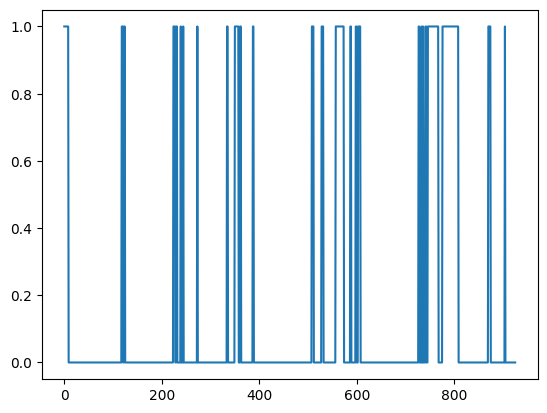

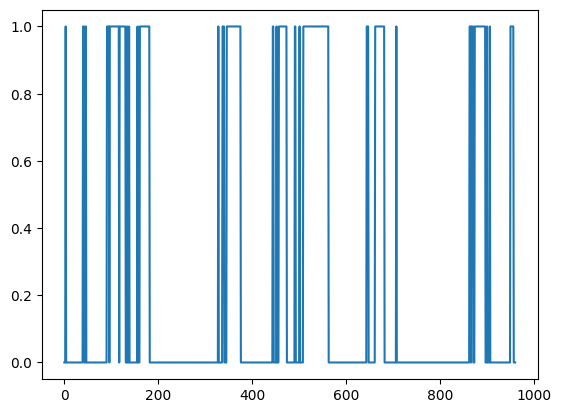

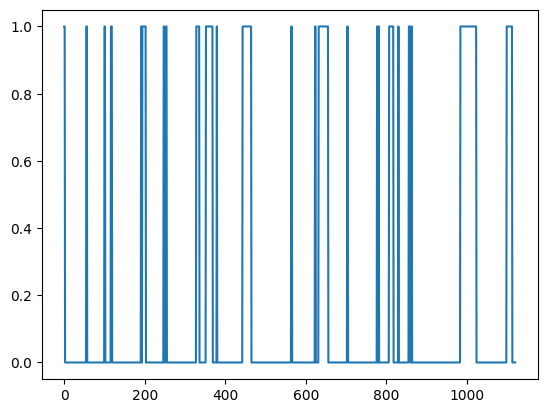

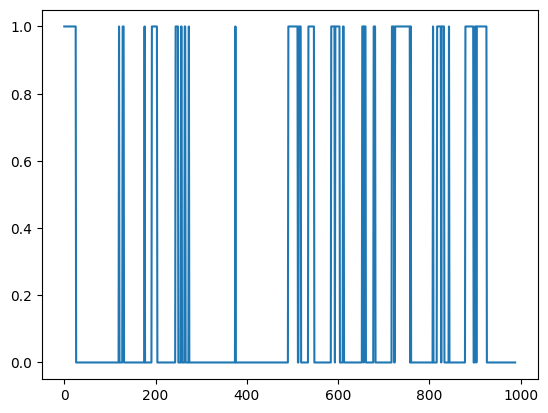

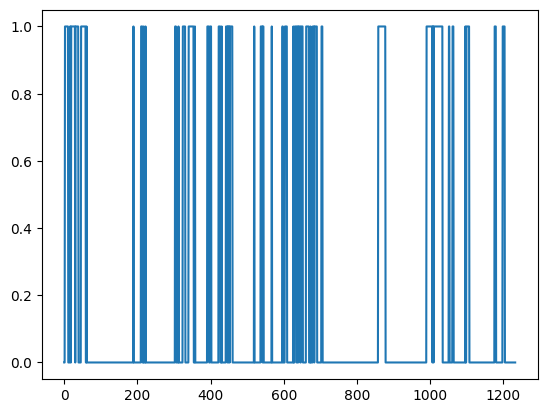

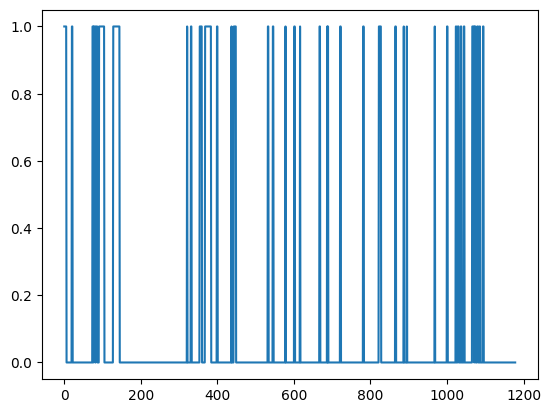

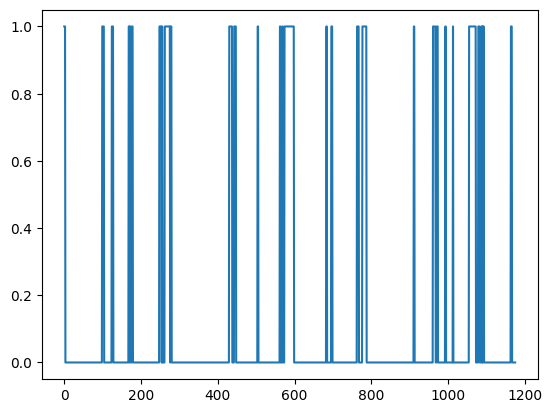

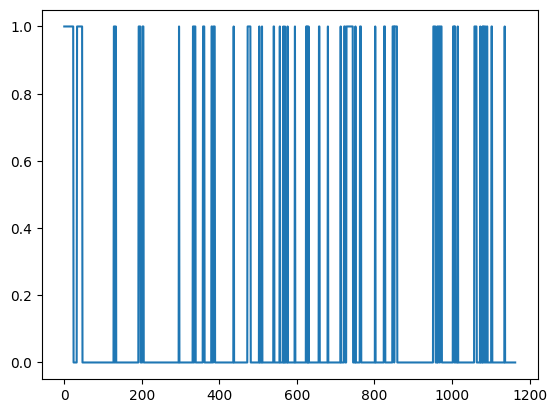

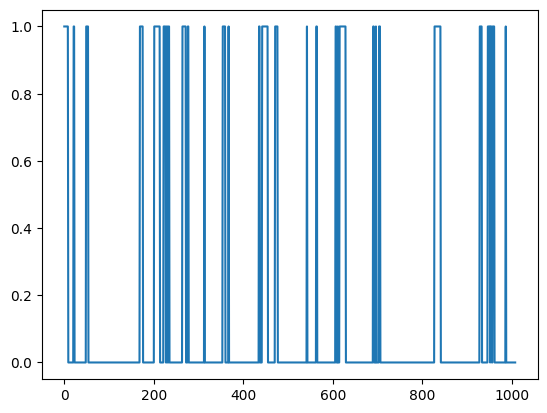

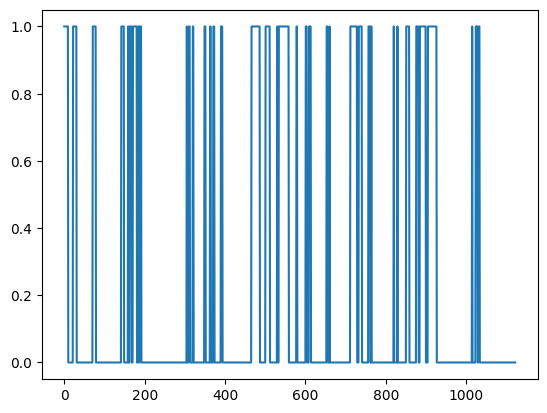

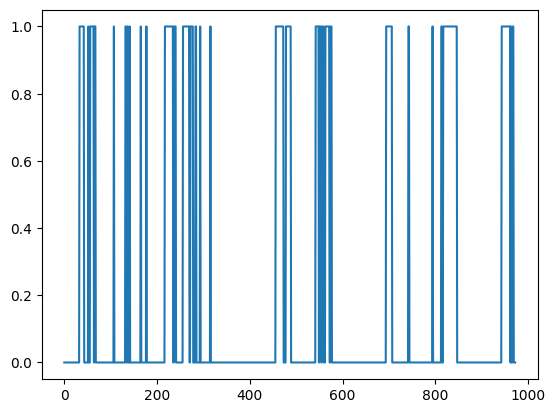

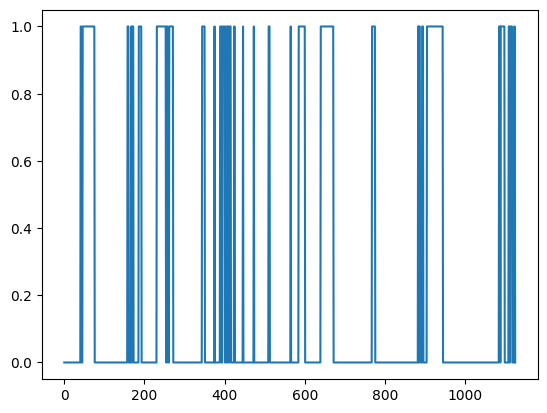

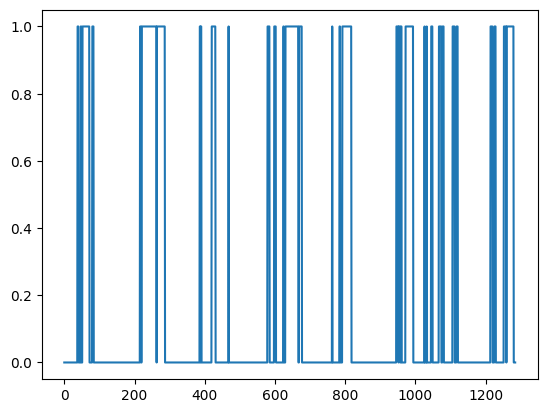

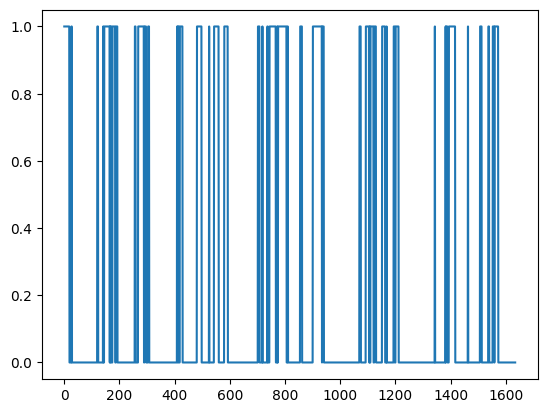

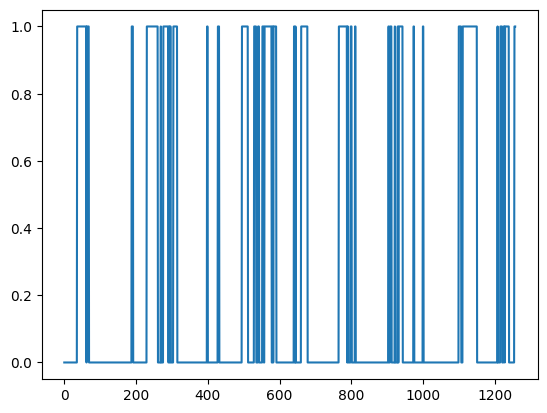

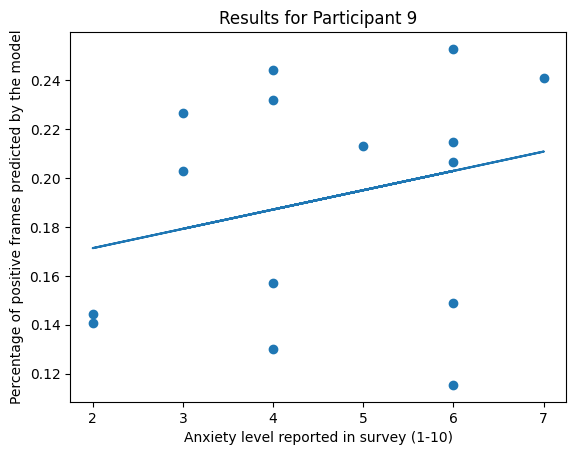

In [ ]:
from collections import defaultdict

import os
filenames = []
for filename in os.listdir("RED_S9_processed"):
    if filename.startswith('0') and filename.endswith(".pickle"):
        filenames.append(filename)

filenames = sorted(filenames)

d = defaultdict(list)
x_9 = []
y_9 = []
TP_total = 0
FP_total = 0
TN_total = 0
FN_total = 0
for fn in filenames:
    pr, gt, TP, FP, TN, FN = evaluate_day(fn, dir = 'RED_S9_processed/')
    TP_total += TP
    FP_total += FP
    TN_total += TN
    FN_total += FN
    x_9.append(gt)
    y_9.append(pr)
    d[gt].append(pr)

acc = (TP_total+TN_total)/(TP_total+FP_total+TN_total+FN_total)
p = TP_total/(TP_total+FP_total)
r = TP_total/(TP_total+FN_total)
F1 = (2*p*r)/(p+r)
print('TP_total:', TP_total, 'FP_total:', FP_total, 'TN_total:', TN_total, 'FN_total:', FN_total)
print('Accuracy:', acc, 'Precision:', p, 'Recall:', r, 'F1:', F1)
x_9 = np.array(x_9)
y_9 = np.array(y_9)
plt.figure()
plt.scatter(x_9, y_9)
plt.xlabel('Anxiety level reported in survey (1-10)')
plt.ylabel('Percentage of positive frames predicted by the model')
plt.title('Results for Participant 9')
a, b = np.polyfit(x_9, y_9, 1)
plt.plot(x_9, a*x_9+b)
sorted_keys = sorted(d.keys())
for key in sorted_keys:
    print('mean pr for anxiety level', key, '=', np.mean(d[key]))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

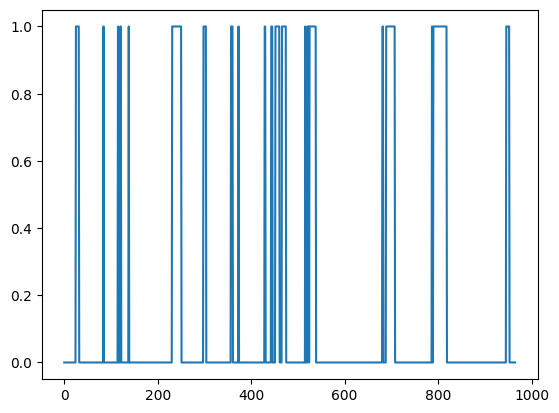

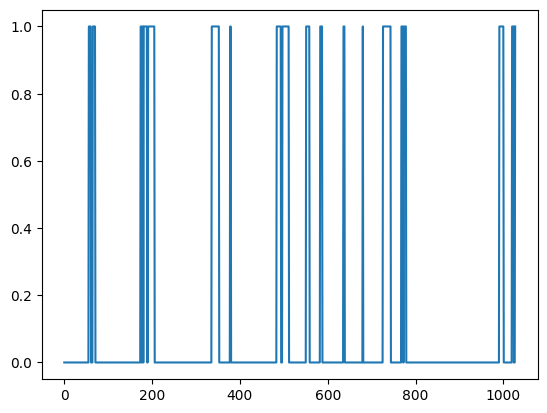

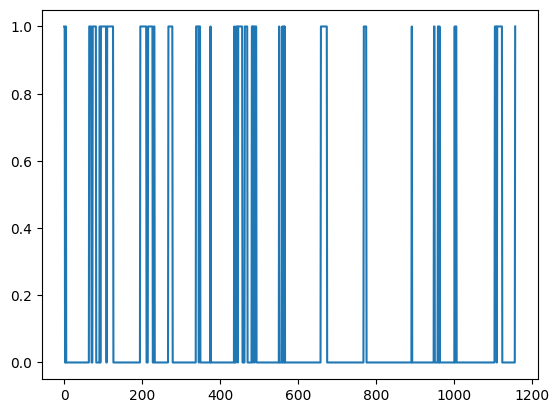

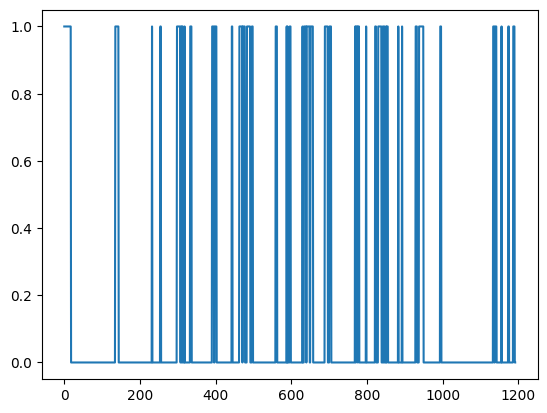

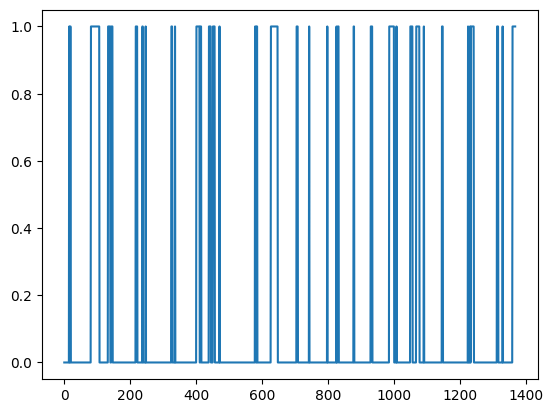

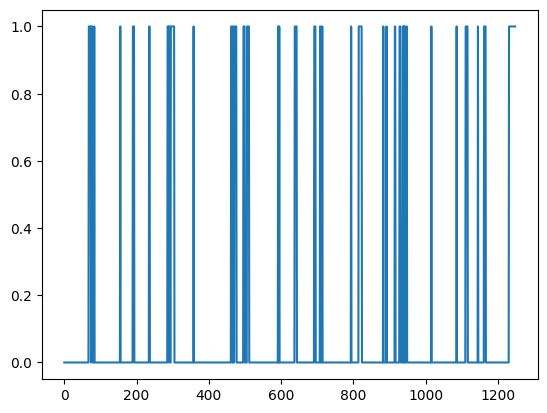

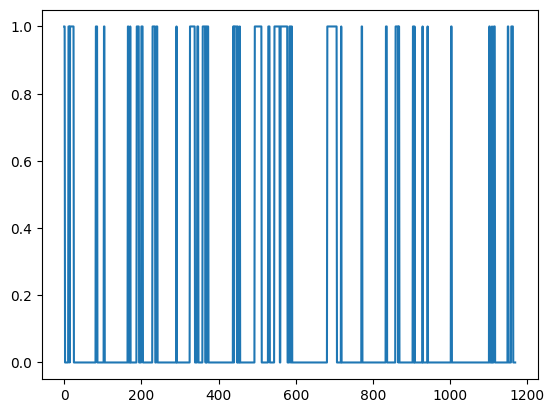

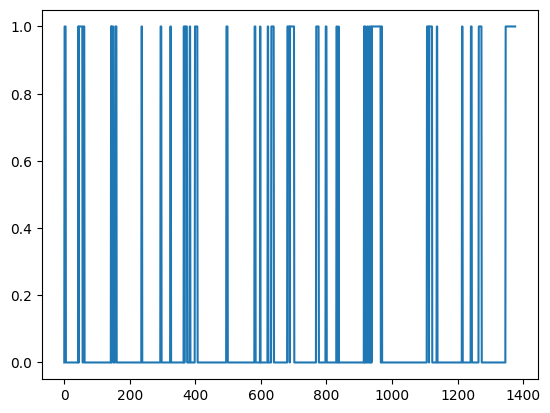

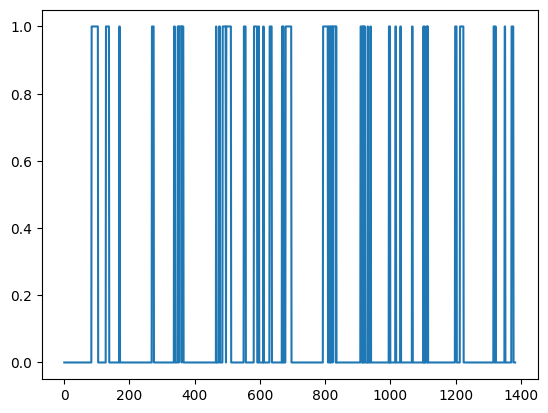

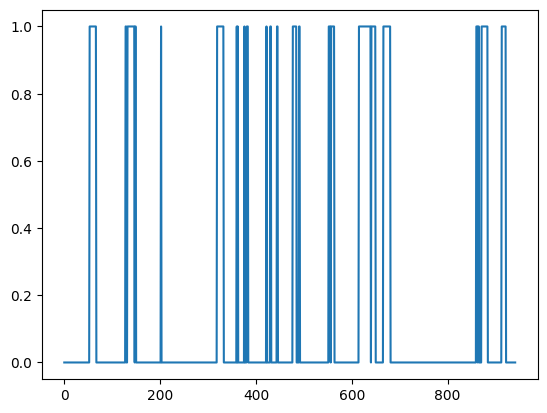

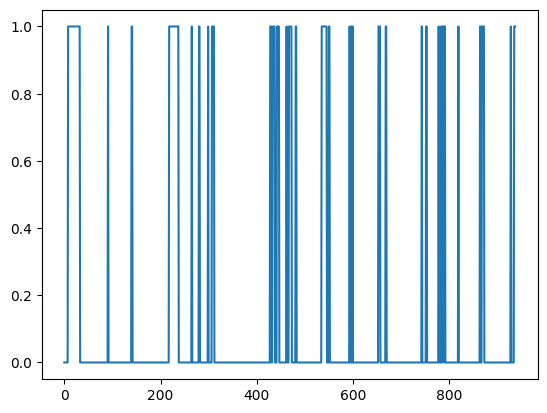

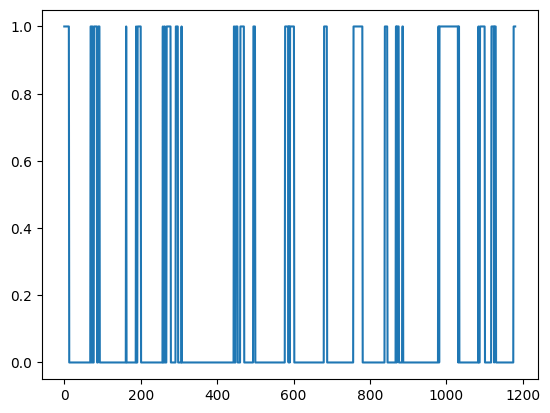

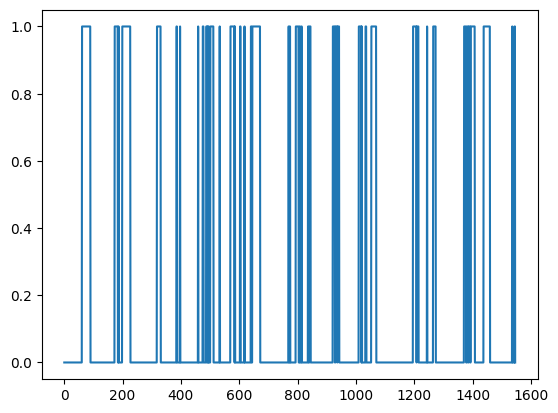

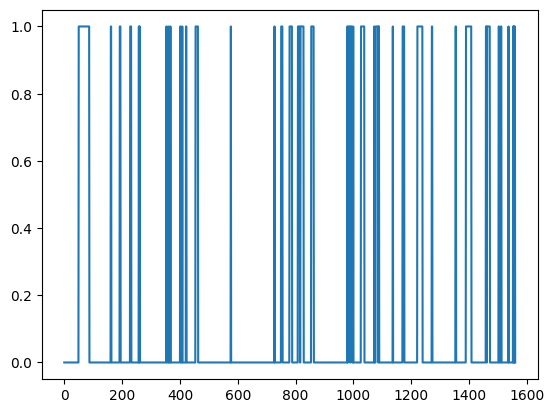

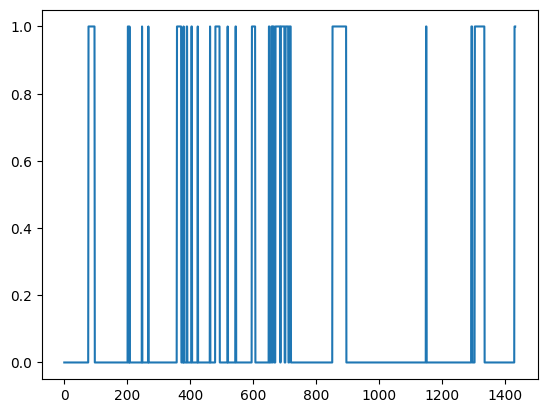

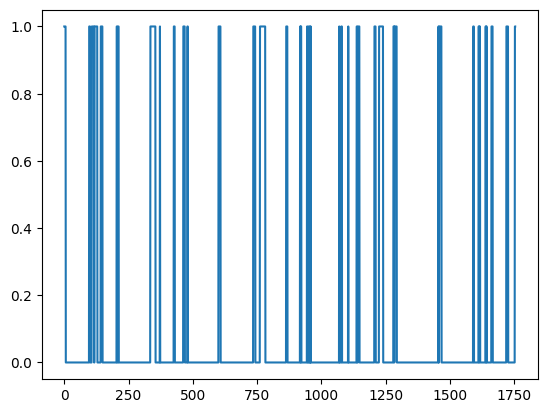

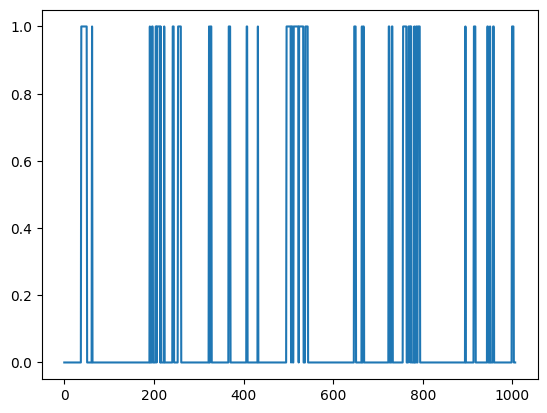

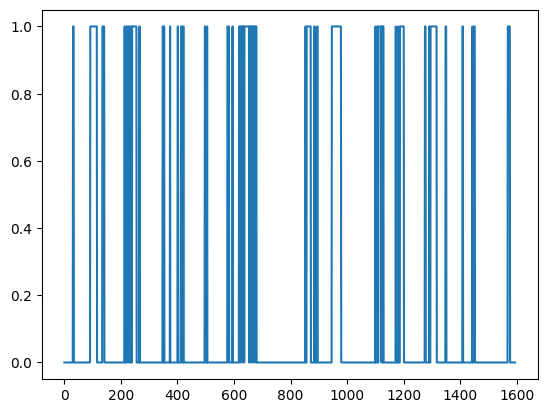

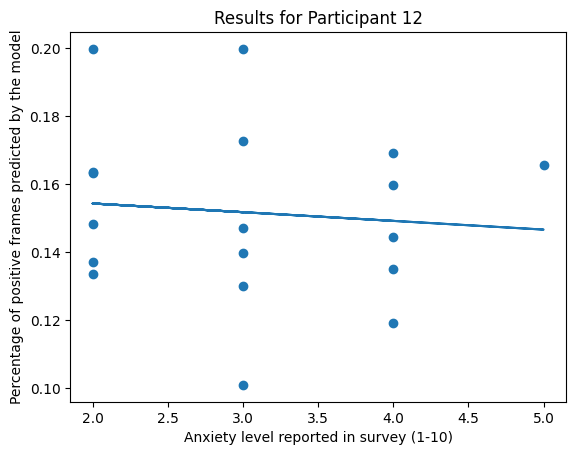

In [ ]:
from collections import defaultdict

import os
filenames = []
for filename in os.listdir("RED_S12_processed"):
    if filename.endswith(".pickle"):
        filenames.append(filename)

filenames = sorted(filenames)

d = defaultdict(list)
x_12 = []
y_12 = []
TP_total = 0
FP_total = 0
TN_total = 0
FN_total = 0
for fn in filenames:
    pr, gt, TP, FP, TN, FN = evaluate_day(fn, dir = 'RED_S12_processed/')
    TP_total += TP
    FP_total += FP
    TN_total += TN
    FN_total += FN
    x_12.append(gt)
    y_12.append(pr)
    d[gt].append(pr)

acc = (TP_total+TN_total)/(TP_total+FP_total+TN_total+FN_total)
p = TP_total/(TP_total+FP_total)
r = TP_total/(TP_total+FN_total)
F1 = (2*p*r)/(p+r)
print('TP_total:', TP_total, 'FP_total:', FP_total, 'TN_total:', TN_total, 'FN_total:', FN_total)
print('Accuracy:', acc, 'Precision:', p, 'Recall:', r, 'F1:', F1)
x_12 = np.array(x_12)
y_12 = np.array(y_12)
plt.figure()
plt.scatter(x_12, y_12)
plt.xlabel('Anxiety level reported in survey (1-10)')
plt.ylabel('Percentage of positive frames predicted by the model')
plt.title('Results for Participant 12')
a, b = np.polyfit(x_12, y_12, 1)
plt.plot(x_12, a*x_12+b)
sorted_keys = sorted(d.keys())
for key in sorted_keys:
    print('mean pr for anxiety level', key, '=', np.mean(d[key]))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

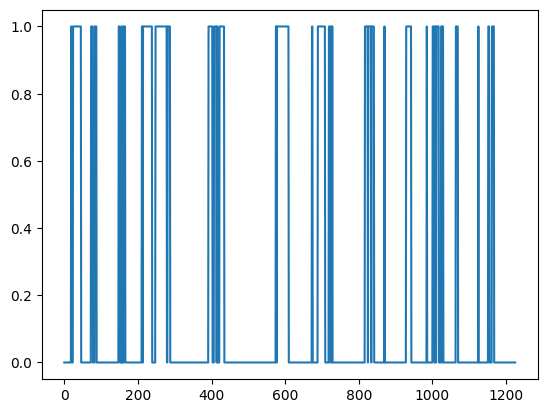

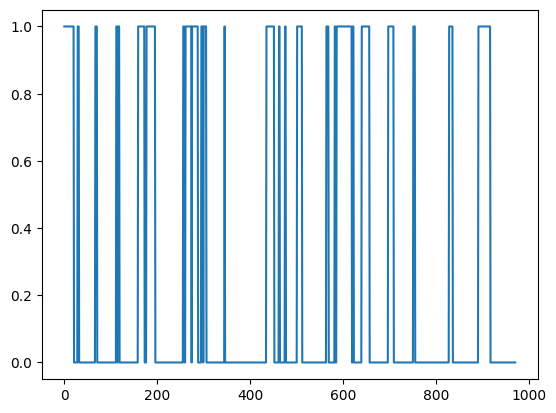

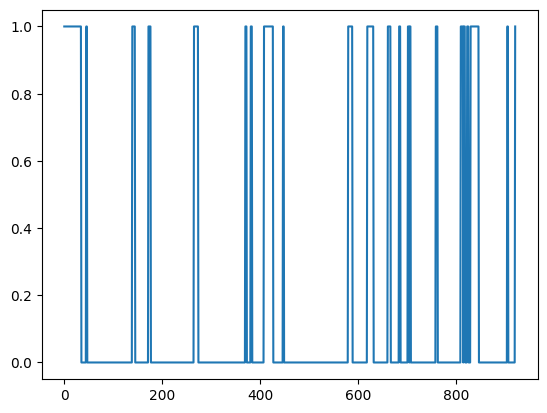

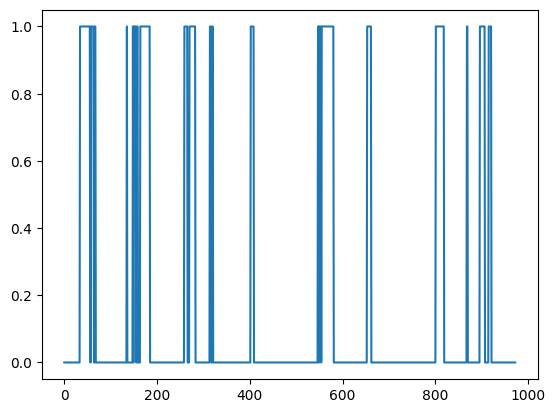

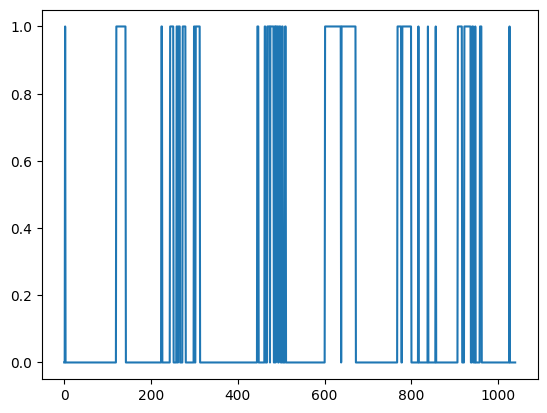

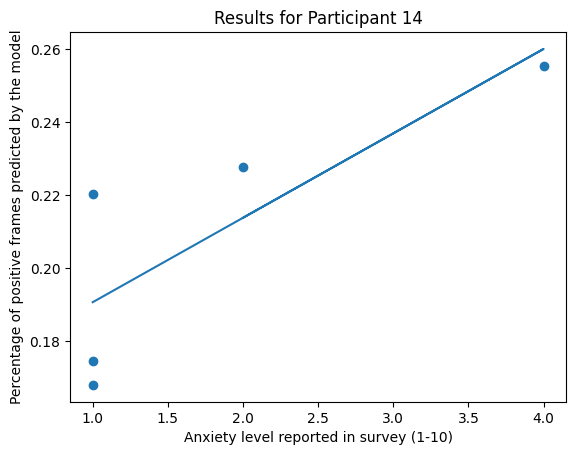

In [ ]:
from collections import defaultdict

import os
filenames = []
for filename in os.listdir("RED_S14_processed"):
    if filename.endswith(".pickle"):
        filenames.append(filename)

filenames = sorted(filenames)

d = defaultdict(list)
x_14 = []
y_14 = []
TP_total = 0
FP_total = 0
TN_total = 0
FN_total = 0
for fn in filenames:
    pr, gt, TP, FP, TN, FN = evaluate_day(fn, dir = 'RED_S14_processed/')
    TP_total += TP
    FP_total += FP
    TN_total += TN
    FN_total += FN
    x_14.append(gt)
    y_14.append(pr)
    d[gt].append(pr)

acc = (TP_total+TN_total)/(TP_total+FP_total+TN_total+FN_total)
p = TP_total/(TP_total+FP_total)
r = TP_total/(TP_total+FN_total)
F1 = (2*p*r)/(p+r)
print('TP_total:', TP_total, 'FP_total:', FP_total, 'TN_total:', TN_total, 'FN_total:', FN_total)
print('Accuracy:', acc, 'Precision:', p, 'Recall:', r, 'F1:', F1)
x_14 = np.array(x_14)
y_14 = np.array(y_14)
plt.figure()
plt.scatter(x_14, y_14)
plt.xlabel('Anxiety level reported in survey (1-10)')
plt.ylabel('Percentage of positive frames predicted by the model')
plt.title('Results for Participant 14')
a, b = np.polyfit(x_14, y_14, 1)
plt.plot(x_14, a*x_14+b)
sorted_keys = sorted(d.keys())
for key in sorted_keys:
    print('mean pr for anxiety level', key, '=', np.mean(d[key]))

TP: 3974 FP: 3881 TN: 19406 FN: 17874
Accuracy: 0.518001550902847 Precision: 0.505919796308084 Recall: 0.18189307945807395 F1: 0.26758239908426756


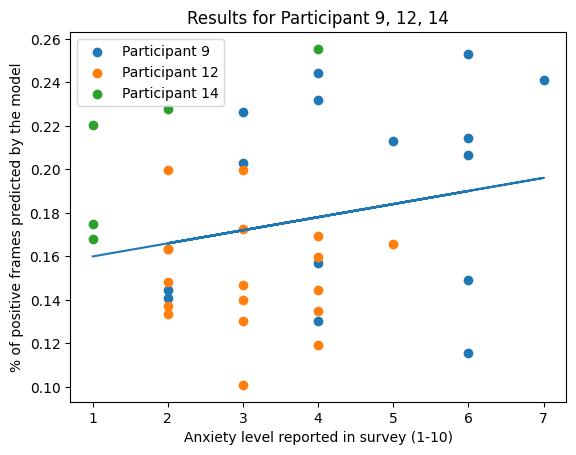

In [ ]:
#TP_total: 2527 FP_total: 784 TN_total: 3610 FN_total: 10235
#TP_total: 1199 FP_total: 2267 TN_total: 12468 FN_total: 6916
#TP_total: 248 FP_total: 833 TN_total: 3328 FN_total: 723

TP_three_p = 2527+1199+248
FP_three_p = 784+2264+833
TN_three_p = 3610+12468+3328
FN_three_p = 10235+6916+723

acc = (TP_three_p+TN_three_p)/(TP_three_p+FP_three_p+TN_three_p+FN_three_p)
p = TP_three_p/(TP_three_p+FP_three_p)
r = TP_three_p/(TP_three_p+FN_three_p)
F1 = (2*p*r)/(p+r)

print('TP:', TP_three_p, 'FP:', FP_three_p, 'TN:', TN_three_p, 'FN:', FN_three_p)
print('Accuracy:', acc, 'Precision:', p, 'Recall:', r, 'F1:', F1)

plt.figure()
plt.scatter(x_9, y_9, label='Participant 9')
plt.scatter(x_12, y_12, label='Participant 12')
plt.scatter(x_14, y_14, label='Participant 14')
x_total = np.array((*x_9, *x_12, *x_14))
y_total = np.array((*y_9, *y_12, *y_14))
plt.xlabel('Anxiety level reported in survey (1-10)')
plt.ylabel('% of positive frames predicted by the model')
plt.title('Results for Participant 9, 12, 14')
a, b = np.polyfit(x_total, y_total, 1)
plt.plot(x_total, a*x_total+b)
plt.legend()